In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng()

# Gillespie Simulations for Colorectal Cancer

## Poisson Process Simulation

For the Poisson Process, there is only one possible event, so we only need to generate the time between events. To do this, we need to generate an exponential random variable with the rate of our Poisson process.

In [5]:
# help(np.random.Generator.exponential)
rate = .1
print(rng.exponential(1/rate))

20.732296823006536


In [6]:
def nextEventTime(lamb):
	return rng.exponential(1/lamb) # This function generates an instance of an exponential random variable

Then, we can use a for loop to simulate an instance of the Poisson process up to a fixed time.

In [7]:
maxIterations = 1e6 # This is used so that we don't enter a (nearly) infinite loop

def PoissonProcess(maxT,rate):
	ts = [0] #Timepoints when events occur
	ns = [0] #Total number of events that have occured at each timepoint

	for i in range(int(maxIterations)):
		newT = ts[-1] + nextEventTime(rate) # Generate the next event time
		if newT > maxT: # Check if maxT has been reached
			break
		ts.append(newT) # Record time
		ns.append(ns[-1] + 1) # Record new value
	
	ts.append(maxT) # Add the data point for the maxT
	ns.append(ns[-1])
	
	return ts,ns


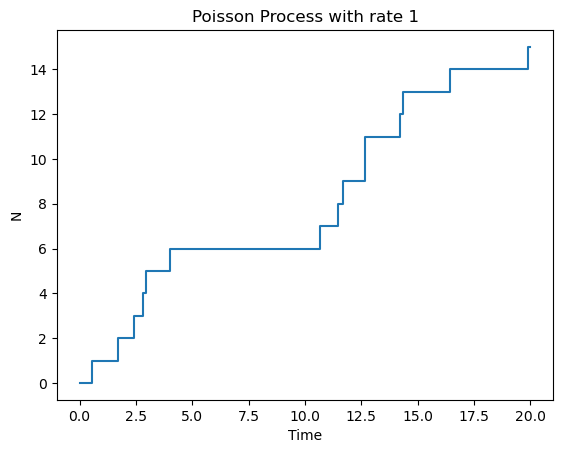

In [8]:
T_max = 20
U = 1

Ts,Ns = PoissonProcess(T_max,U)

plt.step(Ts,Ns,where="post")
plt.xlabel("Time")
plt.ylabel("N")
plt.title("Poisson Process with rate " + str(U))
plt.show()

We can use simulations to compute $P(N(t) \leq n)$ for specific values of $n$

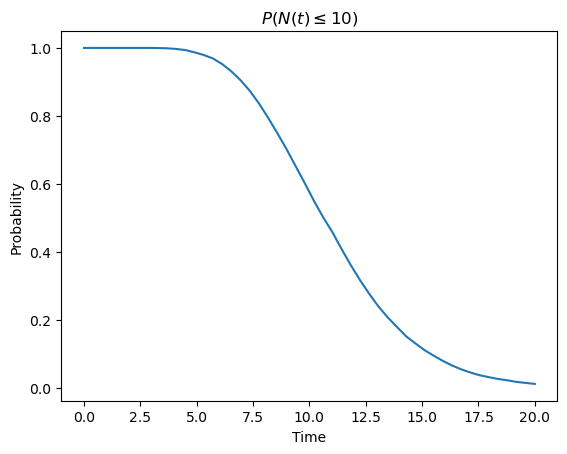

In [9]:
T_max = 20
U = 1

N = 10
t_vals = np.linspace(0,T_max) # Set of t_values that we compute the probability at
p_vals = np.zeros(len(t_vals)) # Initialize probabilities as 0
numSimulations = 10000 #Start at a small number and increase

for i in range(numSimulations):
	Ts,Ns = PoissonProcess(T_max,U) # Run simulation

	if Ns[-1] >= N+1: # Check if a value bigger than target n was reached
		t_target = Ts[N+1] # Find the value of t at which the target was reached
		idx = int(np.ceil(t_target * (len(t_vals)-1) / T_max)) # Find the index in t_vals where the target was reached
		p_vals[:idx] += 1/numSimulations # Increment p values corresponding to correct times
	else:
		p_vals += 1/numSimulations # Increment all p values

plt.plot(t_vals,p_vals)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.title(fr"$P(N(t) \leq {str(N)})$")
plt.show()

We can compare this simulated distribution function to the analytic one we computed

In [10]:
def Poisson_analyticCDF(n,t,rate):
	return sum([((rate*t)**x)/math.factorial(x)*np.exp(-rate*t) for x in range(n+1)])

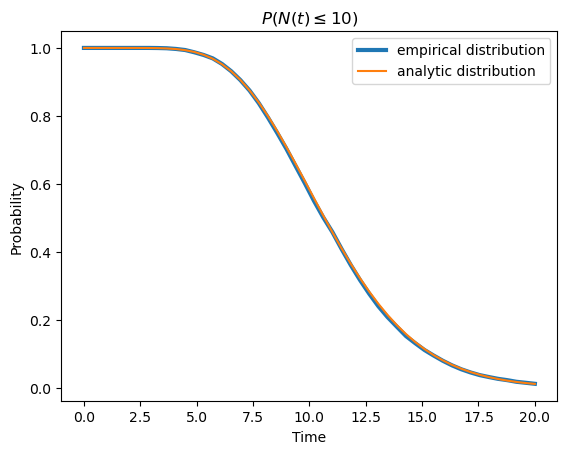

In [11]:
p_analytic_vals = [Poisson_analyticCDF(N,t,U) for t in t_vals]

plt.plot(t_vals,p_vals,label="empirical distribution",linewidth=3.0)
plt.plot(t_vals,p_analytic_vals,label="analytic distribution")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend()
plt.title(fr"$P(N(t) \leq {str(N)})$")
plt.show()

We can do the same for specific values of $t$

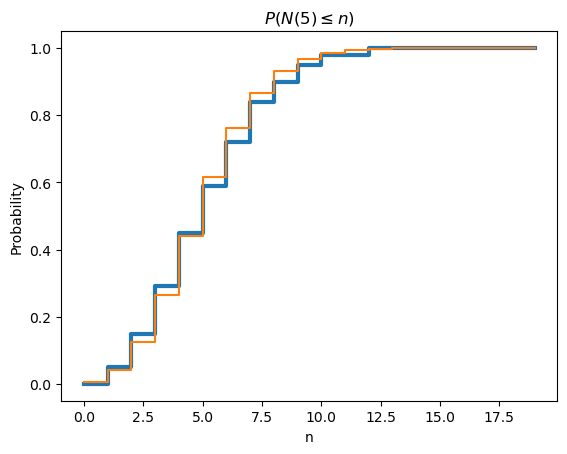

In [12]:
T_max = 20
U = 1

T = 5### # Specific T value that we care about

n_vals = np.arange(0,20) # Set of n_values that we compute the probability at
p_vals = np.zeros(len(n_vals)) # Initialize probabilities as 0
numSimulations = 100 #Start at a small number and increase

for i in range(numSimulations):
	Ts,Ns = PoissonProcess(T_max,U) # Run simulation

	idx = 0
	while Ts[idx] != T and Ts[idx + 1] < T:
		idx += 1

	p_vals[Ns[idx]:] += 1/numSimulations # Increment p values corresponding to correct n values

p_analytic_vals = [Poisson_analyticCDF(n,T,U) for n in n_vals]

plt.step(n_vals,p_vals,where="post",label="empirical distribution",linewidth=3.0)
plt.step(n_vals,p_analytic_vals,where="post",label="analytic distribution")
plt.xlabel("n")
plt.ylabel("Probability")
plt.title(fr"$P(N({str(T)}) \leq n)$")
plt.show()

## Birth-Death Process

Consider a population of cells that starts with $N_0$ individuals with a per-capita birth rate of $b$ per year and a death rate of $d$ per year. We can use the Gillespie algorithm to simulate these processes to learn more about them. In this case, for each event that happens, we have to choose which event happens and update the population accordingly.

In [18]:
birth = 0.3
death = 0.6

event = rng.uniform(0,0.9) # Generate a uniform random variable from 0 to the sum of the rates
if event < 0.3: 
	print("birth")
else:
	print("death")

birth


In [19]:
maxIterations = 1e7 # This is used so that we don't enter a (nearly) infinite loop

def BDProcess(N0,maxT,b,d):
	ts = [0]
	ns = [N0]

	for i in range(int(maxIterations)):
		totalRate = (b+d)*ns[-1] # Compute the sum of the rates of each event

		newT = ts[-1] + nextEventTime(totalRate) # Generate next event time
		if newT > maxT: # Check if maxT has been reached
			break
		ts.append(newT)

		event = rng.uniform(0,totalRate)
		if event < b*ns[-1]:
			ns.append(ns[-1] + 1) # Add 1 to the population
		else:
			ns.append(ns[-1] - 1) # Remove 1 from the population

		if ns[-1] == 0: # Check if population has died out
			break
	
	return ts,ns

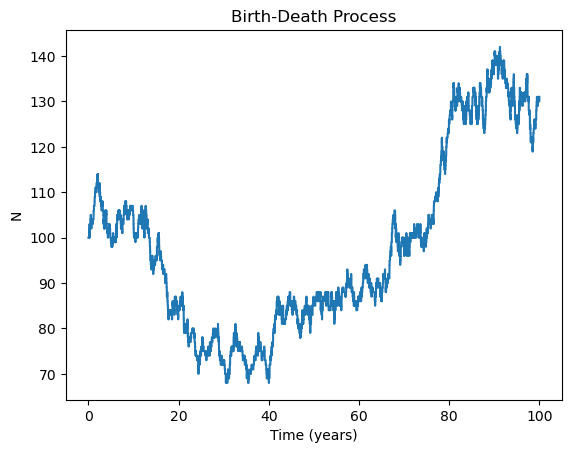

In [20]:
T_max = 100
N_init = 100

birth = 0.1
death = 0.1

Ts,Ns = BDProcess(N_init,T_max,birth,death)

    


plt.step(Ts,Ns,where="post")
plt.xlabel("Time (years)")
plt.ylabel("N")
plt.title("Birth-Death Process")
plt.show()

If b=d then goes to N0 on average

I added this on my own 

Note this can take too long to run if N and Tmax are large

In [21]:


#nfinal = np.zeros(1000)
#for i in range(1000):
#    Ts,Ns = BDProcess(N_init,T_max,0.1,0.1)
#    nfinal[i] = Ns[-1]
#    
#print(np.mean(nfinal))

## Two-Population Birth-Death Process

What if we added a second population to the process. Let $N_0(t)$ be the number of *wild-type* cells in the population and let $N_1(t)$ be number of cells that have a mutation which gives them a selective growth advantage. Suppose each wild-type cell has a mutation rate $u_1$ and once a cell is mutated, its birth rate increases from $b_0$ to $b_1$, with the same death rate $d$. Let's simulate this process

We can use np.cumsum to help us choose which event happens

In [22]:
test_list = [0.1,0.3,0.5]
sum_test_list = np.cumsum(test_list)
print(sum_test_list)

[0.1 0.4 0.9]


In [23]:
def BD_2_Process(n0,maxT,b0,b1,d,u1):
	ts = [0]
	n0s = [n0]
	n1s = [0]

	for i in range(int(maxIterations)):
		event_rates = [b0*n0s[-1], d*n0s[-1], u1*n0s[-1], b1*n1s[-1], d*n1s[-1]]
		sum_event_rates = np.cumsum(event_rates) # Compute the cumulative sums of event rates
		totalRate = sum_event_rates[-1] # Compute the sum of the rates of each event

		newT = ts[-1] + nextEventTime(totalRate) # Generate next event time
		if newT > maxT: # Check if maxT has been reached
			break
		ts.append(newT)

		event = rng.uniform(0,totalRate)
		event_num = 0;
		while event > sum_event_rates[event_num]: # Figure our which event happened
			event_num += 1;

		if event_num == 0:
			n0s.append(n0s[-1] + 1) # Add 1 to the wild-type population
			n1s.append(n1s[-1])
		elif event_num == 1:
			n0s.append(n0s[-1] - 1) # Subtract 1 from the wild-type population
			n1s.append(n1s[-1])
		elif event_num == 2:
			n0s.append(n0s[-1] - 1) # Add 1 to the mutated population and subtract one from the wild-type population
			n1s.append(n1s[-1] + 1)
		elif event_num == 3:
			n0s.append(n0s[-1]) # Add 1 to the mutated population
			n1s.append(n1s[-1] + 1)
		else:
			n0s.append(n0s[-1]) # Subtract 1 from the mutated population
			n1s.append(n1s[-1] - 1)

		if n0s[-1] == 0 and n1s[-1] == 0: # Check if population has died out
			break
	
	return ts,n0s,n1s

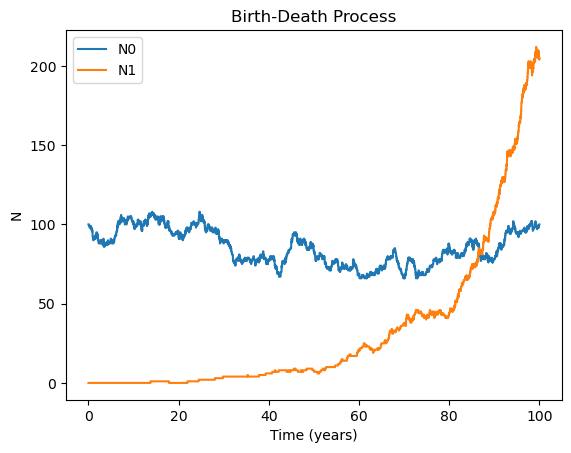

In [27]:
T_max = 100
N_init = 100

birth0 = 0.1
birth1 = 0.15
death = 0.1
mut = 0.0005

Ts,N0s,N1s = BD_2_Process(N_init,T_max,birth0,birth1,death,mut)

plt.step(Ts,N0s,where="post",label="N0")
plt.step(Ts,N1s,where="post",label="N1")
plt.xlabel("Time (years)")
plt.ylabel("N")
plt.title("Birth-Death Process")
plt.legend()
plt.show()